# Rakan's Playground




## Setup

### Package Installing

In [1]:
!pip install spotipy

### Google Drive & Path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import sys
PROJECT_ROOT = '/content/drive/My Drive/UofT/4th Year/APS360/Project/Hit-Song-Prediction/'
sys.path.append(PROJECT_ROOT)

### Internal Imports

In [4]:
from SpotifyConnection import get_spotify_connection
import Playlist as PL
from DataProcessing import normalize_dataframe, SpotifyTracksDataset, normalize_data_by_type, normalize_data, NormalizationType

In [5]:
sp = get_spotify_connection()

### PyTorch/Numpy/Pandas

In [6]:
import numpy as np
import pandas as pd
import random

pd.options.mode.chained_assignment = None  # default='warn'

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [8]:
def seed_torch(seed=0):
  random.seed(seed)

  np.random.seed(seed)
  np.random.RandomState(seed)

  torch.manual_seed(seed) 
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed) #seed all gpus    
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.enabled = False  
  torch.backends.cudnn.benchmark = False

seed_torch(0)

## Loading Data

### Load into DataFrame

Load the feature data from playlist into a dataframe

1.   Audio Features
2.   Track Info
3.   Artist Info
4.   Calculated Info
5.   Genres
6.   Target

#### Loading Function

In [9]:
hit_cutoff = 70

def load_playlist_df(playlist_name):
  pl = PL.load_playlist(PROJECT_ROOT + "playlist_" + playlist_name)

  playlist_info_df = pd.DataFrame()

  ''' Audio Features '''
  playlist_info_df['key'] = pd.Series([x['key'] for x in pl.playlist_information.track_features.values])
  playlist_info_df['mode'] = pd.Series([x['mode'] for x in pl.playlist_information.track_features.values])
  playlist_info_df['time_signature'] = pd.Series([x['time_signature'] for x in pl.playlist_information.track_features.values])
  playlist_info_df['duration'] = pd.Series([x['duration_ms'] / 1000 for x in pl.playlist_information.track_features.values])
  playlist_info_df['acousticness'] = pd.Series([x['acousticness'] for x in pl.playlist_information.track_features.values])
  playlist_info_df['danceability'] = pd.Series([x['danceability'] for x in pl.playlist_information.track_features.values])
  playlist_info_df['energy'] = pd.Series([x['energy'] for x in pl.playlist_information.track_features.values])
  playlist_info_df['instrumentalness'] = pd.Series([x['instrumentalness'] for x in pl.playlist_information.track_features.values])
  playlist_info_df['liveness'] = pd.Series([x['liveness'] for x in pl.playlist_information.track_features.values])
  playlist_info_df['loudness'] = pd.Series([x['loudness'] for x in pl.playlist_information.track_features.values])
  playlist_info_df['speechiness'] = pd.Series([x['speechiness'] for x in pl.playlist_information.track_features.values])
  playlist_info_df['valence'] = pd.Series([x['valence'] for x in pl.playlist_information.track_features.values])
  playlist_info_df['tempo'] = pd.Series([x['tempo'] for x in pl.playlist_information.track_features.values])

  ''' Track Info '''
  playlist_info_df['name'] = pd.Series([x['name'] for x in pl.playlist_information.track_info.values])
  playlist_info_df['explicit'] = pd.Series([x['explicit'] for x in pl.playlist_information.track_info.values])
  playlist_info_df['release_date'] = pd.to_datetime(pd.Series([x['album']['release_date'] for x in pl.playlist_information.track_info.values])).dt.year

  ''' Artist Info '''
  playlist_info_df['artist_followers'] = pd.Series([np.array([x['followers']['total'] for x in y]).max() for y in pl.playlist_information.artists_info.values])
  playlist_info_df['max_artist_popularity'] = pd.Series([np.array([x['popularity'] for x in y]).max() for y in pl.playlist_information.artists_info.values])
  playlist_info_df['avg_popularity_artist_top_tracks'] = pl.artist_top_track_information_df['avg_popularity_artist_top_tracks']
  playlist_info_df['avg_duration_artist_top_tracks'] = pl.artist_top_track_information_df['avg_duration_artist_top_tracks']
  playlist_info_df['avg_acousticness_artist_top_tracks'] = pl.artist_top_track_information_df['avg_acousticness_artist_top_tracks']
  playlist_info_df['avg_danceability_artist_top_tracks'] = pl.artist_top_track_information_df['avg_danceability_artist_top_tracks']
  playlist_info_df['avg_energy_artist_top_tracks'] = pl.artist_top_track_information_df['avg_energy_artist_top_tracks']
  playlist_info_df['avg_instrumentalness_artist_top_tracks'] = pl.artist_top_track_information_df['avg_instrumentalness_artist_top_tracks']
  playlist_info_df['avg_liveness_artist_top_tracks'] = pl.artist_top_track_information_df['avg_liveness_artist_top_tracks']
  playlist_info_df['avg_loudness_artist_top_tracks'] = pl.artist_top_track_information_df['avg_loudness_artist_top_tracks']
  playlist_info_df['avg_speechiness_artist_top_tracks'] = pl.artist_top_track_information_df['avg_speechiness_artist_top_tracks']
  playlist_info_df['avg_valence_artist_top_tracks'] = pl.artist_top_track_information_df['avg_valence_artist_top_tracks']
  playlist_info_df['avg_tempo_artist_top_tracks'] = pl.artist_top_track_information_df['avg_tempo_artist_top_tracks']

  ''' Calculated Info '''
  playlist_info_df['change_from_avg_duration_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_duration_artist_top_tracks'] - playlist_info_df.duration).abs()
  playlist_info_df['change_from_avg_acousticness_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_acousticness_artist_top_tracks'] - playlist_info_df.acousticness).abs()
  playlist_info_df['change_from_avg_danceability_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_danceability_artist_top_tracks'] - playlist_info_df.danceability).abs()
  playlist_info_df['change_from_avg_energy_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_energy_artist_top_tracks'] - playlist_info_df.energy).abs()
  playlist_info_df['change_from_avg_instrumentalness_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_instrumentalness_artist_top_tracks'] - playlist_info_df.instrumentalness).abs()
  playlist_info_df['change_from_avg_liveness_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_liveness_artist_top_tracks'] - playlist_info_df.liveness).abs()
  playlist_info_df['change_from_avg_loudness_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_loudness_artist_top_tracks'] - playlist_info_df.loudness).abs()
  playlist_info_df['change_from_avg_speechiness_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_speechiness_artist_top_tracks'] - playlist_info_df.speechiness).abs()
  playlist_info_df['change_from_avg_valence_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_valence_artist_top_tracks'] - playlist_info_df.valence).abs()
  playlist_info_df['change_from_avg_tempo_artist_top_tracks'] = (pl.artist_top_track_information_df['avg_tempo_artist_top_tracks'] - playlist_info_df.tempo).abs()



  ''' Target '''
  playlist_info_df['popularity'] = pd.Series([x['popularity'] for x in pl.playlist_information.track_info.values])
  playlist_info_df['hit'] = (playlist_info_df.popularity > hit_cutoff)*1


  ''' Genres '''
  genres_df = pl.genres_df
  relevant_genres = ["pop", "hip hop", "rock", "rap"]
  relevant_genres_df = pd.DataFrame(columns=["genres_"+x for x in relevant_genres])

  for index, row in genres_df.iterrows():
    row_info = []
    for relevant_genre in relevant_genres:
      for genre in genres_df.columns:
        genre_found = False
        if (relevant_genre in genre) and (row[genre] == 1):
          row_info.append(1)
          genre_found = True
          break;
      if not genre_found:
        row_info.append(0)

    relevant_genres_df.loc[index] = row_info
  relevant_genres_df = relevant_genres_df.astype(float)

  ''' Add genre data '''
  playlist_info_df = pd.concat([playlist_info_df, relevant_genres_df], axis=1, sort=False)

  ''' Drop missing data '''
  playlist_info_df.dropna(inplace=True)

  return playlist_info_df

#### Load

In [10]:
playlist_name = "4wVOVUOLCGhkwcehwpju6V"

playlist_info_df = load_playlist_df(playlist_name)

Loaded playlist from file: /content/drive/My Drive/UofT/4th Year/APS360/Project/Hit-Song-Prediction/playlist_4wVOVUOLCGhkwcehwpju6V


## Splitting Data

In [11]:
TRAIN_PCT = 0.7
VALID_PCT = 0.15

dataframe_to_use = playlist_info_df

dataset_target = 'hit'
features = list(dataframe_to_use.columns.copy())
features.remove(dataset_target)
features.remove('name')
features.remove('popularity')

''' Scramble DataFrame '''
seed_torch(0)
dataframe_to_use = dataframe_to_use.sample(frac=1).reset_index(drop=True)

''' Split Data '''
num_data = dataframe_to_use.shape[0]

num_train = int(num_data * TRAIN_PCT)
num_val = int(num_data * VALID_PCT)
num_test = num_data - num_train - num_val

train_df = dataframe_to_use.iloc[0:num_train]
val_df = dataframe_to_use.iloc[num_train:num_train+num_val]
test_df = dataframe_to_use.iloc[num_train+num_val:num_data]
full_df = pd.concat([train_df, val_df, test_df], axis=0, sort=False)

all_dfs = [train_df, val_df, test_df, full_df]

In [12]:
train_df.iloc[0]

key                                                                  1
mode                                                                 1
time_signature                                                       4
duration                                                        101.79
acousticness                                                     0.128
danceability                                                     0.626
energy                                                           0.423
instrumentalness                                                     0
liveness                                                          0.18
loudness                                                        -6.035
speechiness                                                     0.0513
valence                                                          0.571
tempo                                                           95.162
name                                                  Walls Could Talk
explic

## Balancing Data

In [13]:
def get_balanced_classification_df(df, hit_cutoff):

  main_df = df.copy()

  hit_df = main_df[main_df.hit == 1]
  non_hit_df = main_df[main_df.hit == 0]

  hit_count = hit_df.shape[0]
  non_hit_count = non_hit_df.shape[0]

  if hit_count > non_hit_count:
    diff = hit_count - non_hit_count
    for i in range(0, int(diff/non_hit_count)):
      extra_data = non_hit_df.iloc[0:diff]
      main_df = main_df.append(extra_data, ignore_index=True)

    extra_data = non_hit_df.iloc[0:int(diff%non_hit_count)]
    main_df = main_df.append(extra_data, ignore_index=True)

  else:
    diff = non_hit_count - hit_count
    for i in range(0,int(diff/hit_count)):
      extra_data = hit_df.iloc[0:diff]
      main_df = main_df.append(extra_data, ignore_index=True)
    extra_data = hit_df.iloc[0:int(diff%hit_count)]
    main_df = main_df.append(extra_data, ignore_index=True)

  return main_df

## Cleaning Data


### Normalizing

#### Normalize Functions

In [14]:
def get_normalization_values(train_df):
  normalization_values = {
      "time_signature":
      {
          "min":train_df.time_signature.min(),
          "max":train_df.time_signature.max()
      },
      "key":
      {
          "min":train_df.key.min(),
          "max":train_df.key.max()
      },
      "release_date":
      {
          "min":2020-train_df.release_date.max(),
          "max":2020-train_df.release_date.min()
      },
      "duration":
      {
          "min":train_df.duration.mean()-train_df.duration.std(),
          "max":train_df.duration.mean()+train_df.duration.std()
      },
      "tempo":
      {
          "min":train_df.tempo.min(),
          "max":train_df.tempo.max()
      },
      "loudness":
      {
          "min":train_df.loudness.min(),
          "max":train_df.loudness.max()
      },
      "artist_followers":
      {
          "min":train_df.artist_followers.min(),
          "max":train_df.artist_followers.max()
      }
  }
  return normalization_values

def normalize_function(df, normalization_values):
  df.time_signature = normalize_data(df.time_signature, data_min=normalization_values["time_signature"]["min"], data_max=normalization_values["time_signature"]["max"])
  df.time_signature.clip(lower=0, upper=1, inplace=True)
  df.key = normalize_data(df.key, data_min=normalization_values["key"]["min"], data_max=normalization_values["key"]["max"])
  df.key.clip(lower=0, upper=1, inplace=True)
  df.release_date = 2020-df.release_date
  df.release_date = normalize_data(df.release_date, data_min=normalization_values["release_date"]["min"], data_max=normalization_values["release_date"]["max"])
  df.release_date.clip(lower=0, upper=1, inplace=True)


  df.duration = normalize_data(df.duration, data_min=normalization_values["duration"]["min"], data_max=normalization_values["duration"]["max"])
  df.duration.clip(lower=0, upper=1, inplace=True)
  df.avg_duration_artist_top_tracks = normalize_data(df.avg_duration_artist_top_tracks, data_min=normalization_values["duration"]["min"], data_max=normalization_values["duration"]["max"])
  df.avg_duration_artist_top_tracks.clip(lower=0, upper=1, inplace=True)
  df.change_from_avg_duration_artist_top_tracks = normalize_data(df.change_from_avg_duration_artist_top_tracks, data_min=0, data_max=normalization_values["duration"]["max"]-normalization_values["duration"]["min"])
  df.change_from_avg_duration_artist_top_tracks.clip(lower=0, upper=1, inplace=True)

  df.tempo = normalize_data(df.tempo, data_min=normalization_values["tempo"]["min"], data_max=normalization_values["tempo"]["max"])
  df.tempo.clip(lower=0, upper=1, inplace=True)
  df.avg_tempo_artist_top_tracks = normalize_data(df.avg_tempo_artist_top_tracks, data_min=normalization_values["tempo"]["min"], data_max=normalization_values["tempo"]["max"])
  df.avg_tempo_artist_top_tracks.clip(lower=0, upper=1, inplace=True)
  df.change_from_avg_tempo_artist_top_tracks = normalize_data(df.change_from_avg_tempo_artist_top_tracks, data_min=0, data_max=normalization_values["tempo"]["max"]-normalization_values["tempo"]["min"])
  df.change_from_avg_tempo_artist_top_tracks.clip(lower=0, upper=1, inplace=True)

  df.loudness = normalize_data(df.loudness, data_min=normalization_values["loudness"]["min"], data_max=normalization_values["loudness"]["max"])
  df.loudness.clip(lower=0, upper=1, inplace=True)
  df.avg_loudness_artist_top_tracks = normalize_data(df.avg_loudness_artist_top_tracks, data_min=normalization_values["loudness"]["min"], data_max=normalization_values["loudness"]["max"])
  df.avg_loudness_artist_top_tracks.clip(lower=0, upper=1, inplace=True)
  df.change_from_avg_loudness_artist_top_tracks = normalize_data(df.change_from_avg_loudness_artist_top_tracks, data_min=0, data_max=normalization_values["loudness"]["max"]-normalization_values["loudness"]["min"])
  df.change_from_avg_loudness_artist_top_tracks.clip(lower=0, upper=1, inplace=True)

  df.artist_followers = normalize_data(df.artist_followers, data_min=normalization_values["artist_followers"]["min"], data_max=normalization_values["artist_followers"]["max"])
  df.artist_followers.clip(lower=0, upper=1, inplace=True)

  df.max_artist_popularity = normalize_data(df.max_artist_popularity, data_min=0, data_max=100)
  df.avg_popularity_artist_top_tracks = normalize_data(df.avg_popularity_artist_top_tracks, data_min=0, data_max=100)

  return df

#### Normalize

In [15]:
normalization_values = get_normalization_values(train_df)

for df in all_dfs:
  df = normalize_function(df, normalization_values)

normalized_train_df = all_dfs[0]
normalized_val_df = all_dfs[1]
normalized_test_df = all_dfs[2]
normalized_full_df = all_dfs[3]

normalized_train_df[features] = normalized_train_df[features].astype(float)
normalized_val_df[features] = normalized_val_df[features].astype(float)
normalized_test_df[features] = normalized_test_df[features].astype(float)
normalized_full_df[features] = normalized_full_df[features].astype(float)

balanced_train_df = get_balanced_classification_df(normalized_train_df, hit_cutoff)
balanced_train_df[features] = balanced_train_df[features].astype(float)

In [16]:
num_hits = full_df.hit.sum()
num_tracks = full_df.shape[0]
print(f"Number of Hits: {num_hits}")
print(f"Total Number of Tracks: {num_tracks}")
print(f"Percent Hits: {round(num_hits/num_tracks * 100,2)} %")

Number of Hits: 498.0
Total Number of Tracks: 3261
Percent Hits: 15.27 %


## Creating Dataset

In [17]:
''' Create Datasets '''
train = SpotifyTracksDataset(train_df, features, dataset_target)
balanced_train = SpotifyTracksDataset(balanced_train_df, features, dataset_target)
val = SpotifyTracksDataset(val_df, features, dataset_target)
test = SpotifyTracksDataset(test_df, features, dataset_target)
full_dataset = SpotifyTracksDataset(full_df, features, dataset_target)

## Exploring Data

In [18]:
train_df.head()

,key,mode,time_signature,duration,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,name,explicit,release_date,artist_followers,max_artist_popularity,avg_popularity_artist_top_tracks,avg_duration_artist_top_tracks,avg_acousticness_artist_top_tracks,avg_danceability_artist_top_tracks,avg_energy_artist_top_tracks,avg_instrumentalness_artist_top_tracks,avg_liveness_artist_top_tracks,avg_loudness_artist_top_tracks,avg_speechiness_artist_top_tracks,avg_valence_artist_top_tracks,avg_tempo_artist_top_tracks,change_from_avg_duration_artist_top_tracks,change_from_avg_acousticness_artist_top_tracks,change_from_avg_danceability_artist_top_tracks,change_from_avg_energy_artist_top_tracks,change_from_avg_instrumentalness_artist_top_tracks,change_from_avg_liveness_artist_top_tracks,change_from_avg_loudness_artist_top_tracks,change_from_avg_speechiness_artist_top_tracks,change_from_avg_valence_artist_top_tracks,change_from_avg_tempo_artist_top_tracks,popularity,hit,genres_pop,genres_hip hop,genres_rock,genres_rap
0,0.090909,1.0,0.8,0.000000,0.12800,0.626,0.423,0.00000,0.1800,0.859914,0.0513,0.571,0.432360,Walls Could Talk,1.0,0.039216,0.167776,0.92,0.804000,0.499185,0.317406,0.642200,0.57170,0.000005,0.143470,0.847089,0.070780,0.42640,0.499848,0.763162,0.189406,0.016200,0.14870,0.000005,0.036530,0.012825,0.019480,0.14460,0.067488,71.0,1.0,1.0,0.0,0.0,0.0
1,0.181818,1.0,0.8,0.893860,0.08320,0.825,0.762,0.00001,0.0753,0.895539,0.2600,0.603,0.436008,God Bless The Dead,1.0,0.411765,0.129488,0.84,0.707000,0.986154,0.096923,0.808600,0.68000,0.000562,0.202020,0.844623,0.187170,0.65030,0.460366,0.092294,0.013723,0.016400,0.08200,0.000551,0.126720,0.050916,0.072830,0.04730,0.024357,42.0,0.0,0.0,1.0,0.0,1.0
2,1.000000,0.0,0.8,0.000000,0.04250,0.809,0.585,0.00000,0.1080,0.833740,0.3210,0.367,0.627109,Solitaire (feat. Migos & Lil Yachty),1.0,0.019608,0.159092,0.86,0.701333,0.517757,0.100855,0.819667,0.61780,0.001528,0.201957,0.857894,0.226553,0.48360,0.658576,0.533746,0.058355,0.010667,0.03280,0.001528,0.093957,0.024153,0.094447,0.11660,0.031467,44.0,0.0,1.0,1.0,0.0,1.0
3,0.818182,1.0,0.8,1.000000,0.03030,0.710,0.815,0.00000,0.1150,0.959082,0.2190,0.602,0.636686,Status Symbol 3 (feat. Buddy),1.0,0.019608,0.023555,0.77,0.600500,0.578959,0.111600,0.710450,0.66785,0.000223,0.275800,0.870965,0.207905,0.45217,0.553848,0.625079,0.081300,0.000450,0.14715,0.000223,0.160800,0.088117,0.011095,0.14983,0.082839,57.0,0.0,1.0,1.0,0.0,1.0
4,0.818182,0.0,0.8,0.754957,0.00068,0.505,0.929,0.00000,0.1670,0.899029,0.0529,0.419,0.354345,I Apologize,0.0,0.039216,0.062097,0.81,0.653000,0.745306,0.002858,0.498900,0.91710,0.000018,0.199730,0.908169,0.079010,0.38070,0.579122,0.009650,0.002178,0.006100,0.01190,0.000018,0.032730,0.009140,0.026110,0.03830,0.224777,42.0,0.0,0.0,0.0,0.0,0.0


71.0

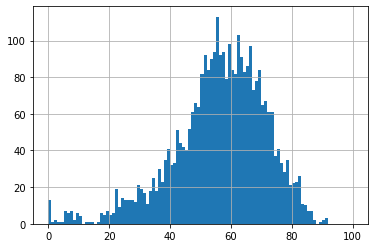

In [19]:
full_df[full_df.popularity > -1].popularity.hist(bins=range(0,101))
full_df.popularity.quantile(0.85)

In [20]:
full_df.corr()['popularity']


key                                                   0.005107
mode                                                 -0.052734
time_signature                                        0.097475
duration                                              0.014865
acousticness                                         -0.024420
danceability                                          0.173783
energy                                                0.020115
instrumentalness                                     -0.175949
liveness                                             -0.081200
loudness                                              0.209961
speechiness                                           0.043007
valence                                              -0.040682
tempo                                                 0.016019
explicit                                              0.220323
release_date                                         -0.261857
artist_followers                                      0

In [21]:
def plot_feature_and_target(dataframe_to_plot, feature, target):
  cols = [feature, target]
  dataframe_to_plot = dataframe_to_plot[cols]
  dataframe_to_plot.plot.scatter(x=feature, y=target)
  return

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


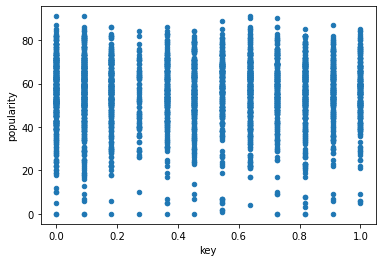

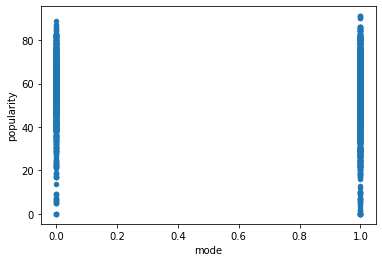

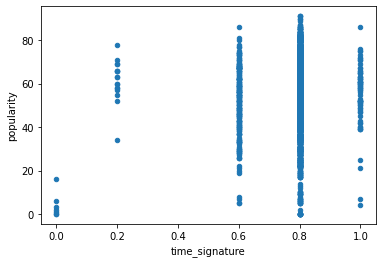

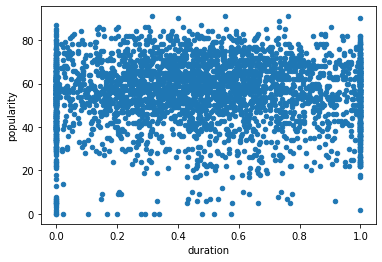

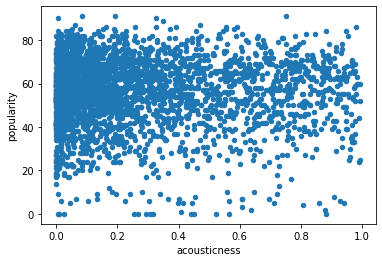

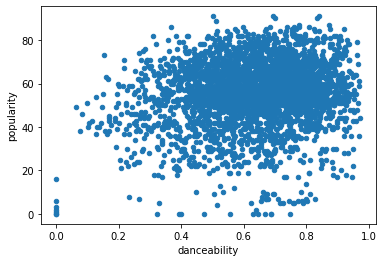

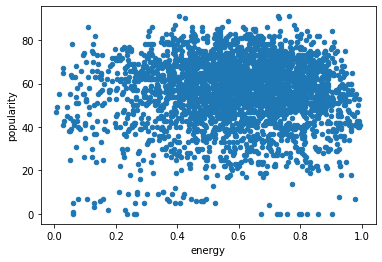

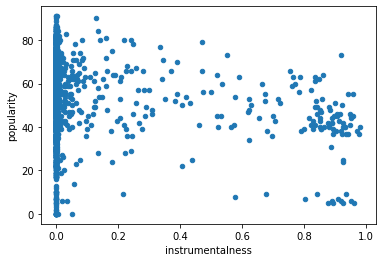

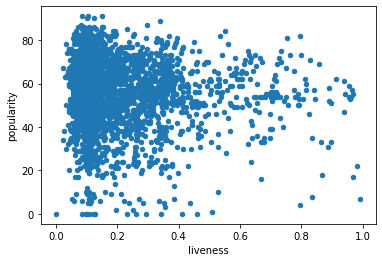

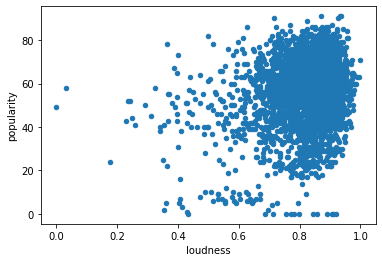

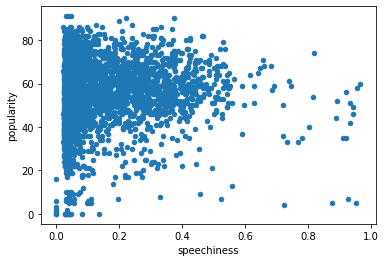

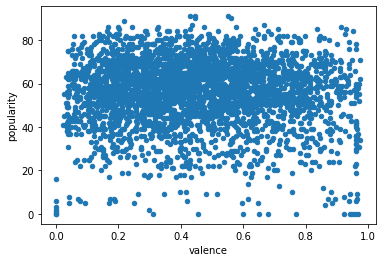

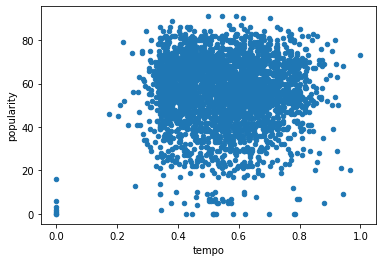

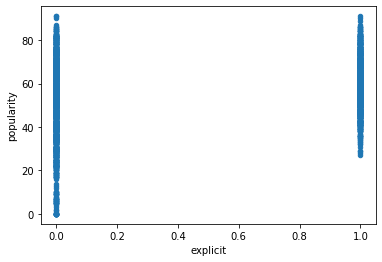

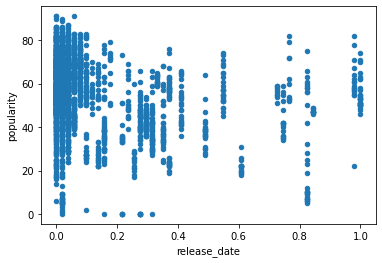

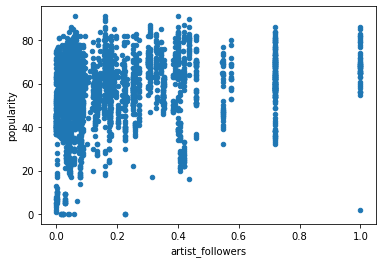

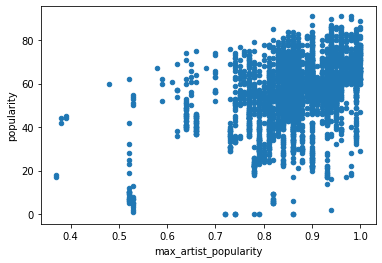

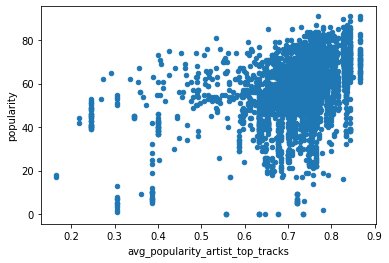

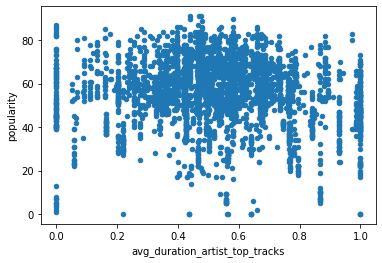

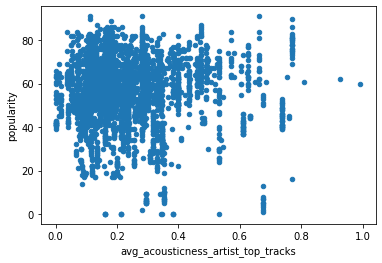

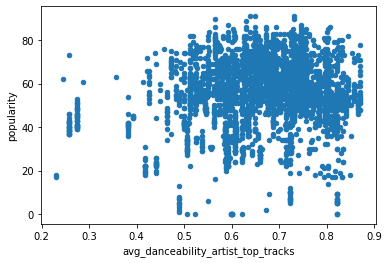

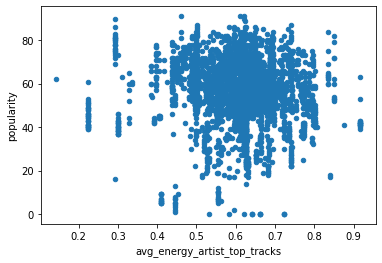

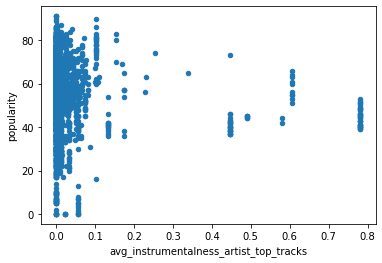

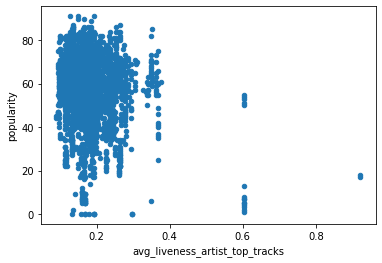

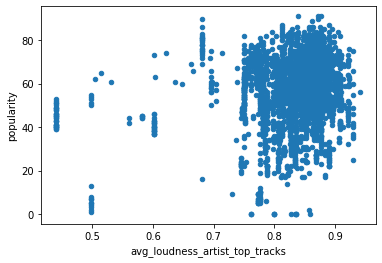

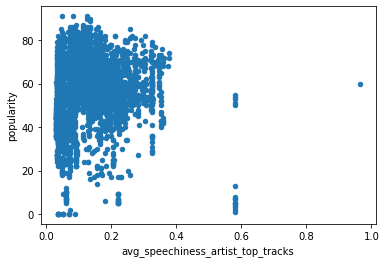

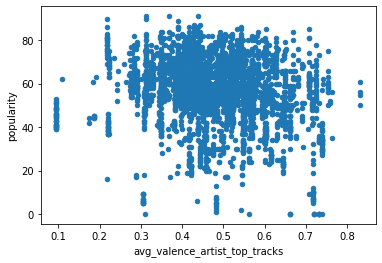

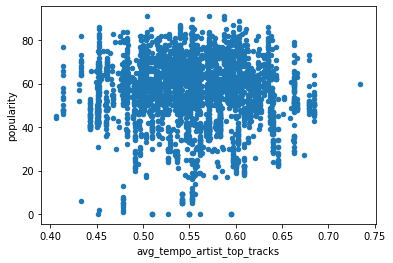

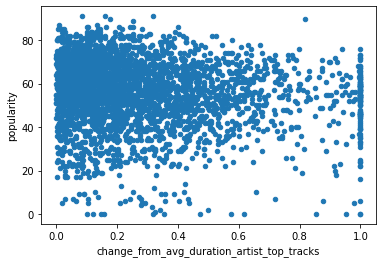

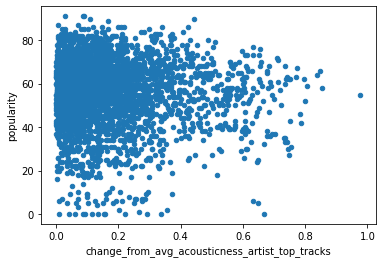

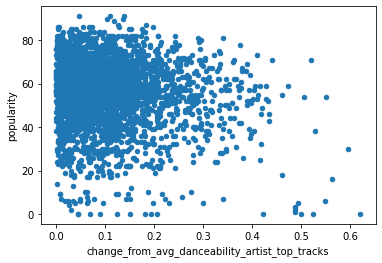

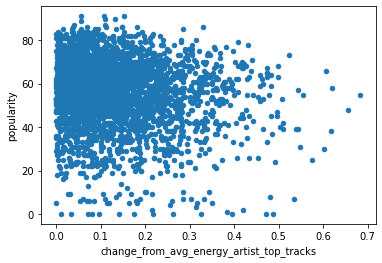

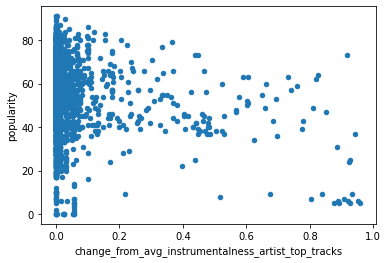

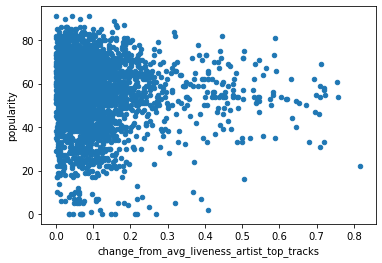

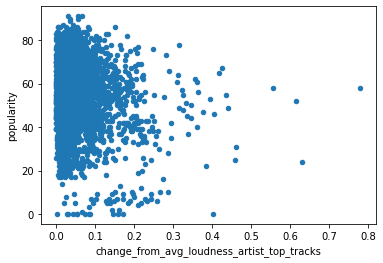

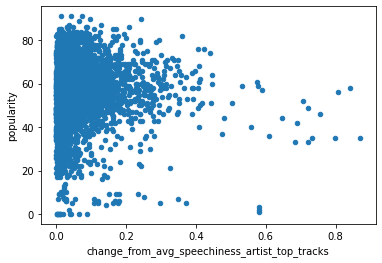

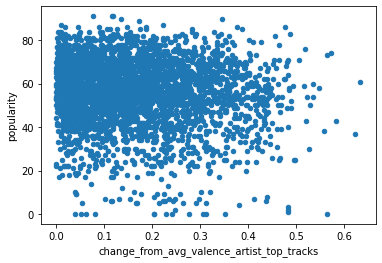

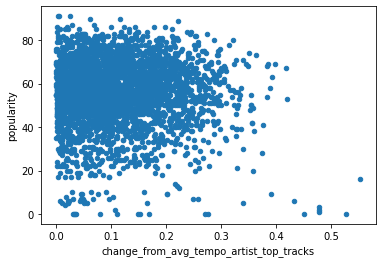

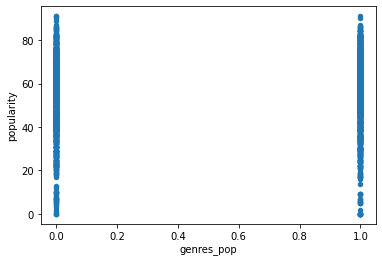

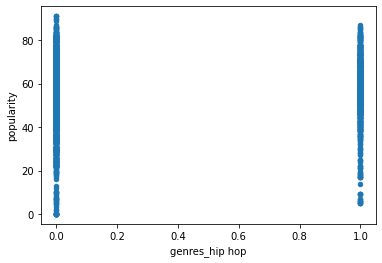

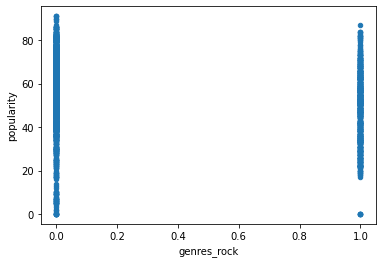

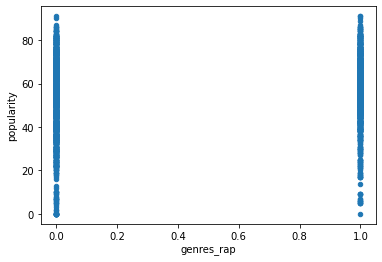

In [22]:
dataframe_to_plot = full_df
target = 'popularity'

for col in features:
  plot_feature_and_target(dataframe_to_plot, col, target)

## Models

In [23]:
class ClassificationNetA(nn.Module):
  def __init__(self):
    super(ClassificationNetA, self).__init__()
    self.name = "ClassificationNetA"
    self.normalization_values = normalization_values
    self.layers = nn.Sequential(
        nn.Linear(len(features), 100),
        nn.Tanh(),
        nn.Linear(100, 50),
        nn.Tanh(),
        nn.Linear(50, 20),
        nn.Tanh(),
        nn.Linear(20, 2)
    ).to(device)


  def forward(self, x):
    x = self.layers(x)
    return x

class RakanNetA(nn.Module):
  def __init__(self):
    super(RakanNetA, self).__init__()
    self.name = "RakanNetA"

    self.normalization_values = None
    self.normalization_values = normalization_values
      
    self.layers = nn.Sequential(
        nn.Linear(len(features), 50),
        nn.Tanh(),
        nn.Linear(50, 20),
        nn.Tanh(),
        nn.Linear(20, 2)
    ).to(device)


  def forward(self, x):
    x = self.layers(x)
    return x

## Training

### Helper Functions

In [24]:
def predict_some(model, data, num_to_predict):
  for i in range(0, num_to_predict):
    k = random.randint(0, len(data)-1)
    features, target = data[k]
    features = features.to(device)
    target = target.to(device)

    out = model(features.unsqueeze(0)).clamp(min=0,max=100)
    print(f"Actual: {round(target.item(), 2)};  Predicted: {round(out.item(), 2)}")

#--------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt

def subsample_series(series, subsampling=1):
  '''
  Subsamples data series
  '''
  indices = np.arange(0,len(series),subsampling)
  subsampled_series = series[indices]
  return indices + 1, subsampled_series

def plot_data(data, multiple_series=False, subsampling=1, labels=None, title="", xlabel="", ylabel="", save_curve=False, file_name=None):
  plt.title(title)
  
  n = len(data)

  if multiple_series:
    for i, series in enumerate(data, 0):
      indices, subsampled_series = subsample_series(np.array(series), subsampling=subsampling)
      if labels:
        plt.plot(indices, subsampled_series, label=labels[i])
      else:
        plt.plot(indices, subsampled_series,)
  else:
    indices, subsampled_series = subsample_series(np.array(data), subsampling=subsampling)
    if labels:
        plt.plot( indices, subsampled_series, label=labels)
    else:
      plt.plot( indices, subsampled_series)

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  
  if labels:
    plt.legend(loc='best')
  
  if save_curve and (file_name is not None):
    plt.savefig(file_name+'.png')
  plt.show()
#--------------------------------------------------------------------------------------------------------
def get_error_classification(model, data):
  model.eval()
  data_loader = torch.utils.data.DataLoader(data, batch_size=100)

  total_error = 0
  for features, targets in data_loader:
    features = features.to(device)
    targets = targets.to(device)

    targets = targets.squeeze(1).long()

    out = model(features)
    out = torch.softmax(out, dim=1)
    total_error += out.argmax(dim=1).eq(targets).sum().item()
  
  error_rate = 1 - (total_error/len(data))
  return error_rate

def get_stats_classification(model, data, criterion, bs=100):
  model.eval()
  data_loader = torch.utils.data.DataLoader(data, batch_size=bs)

  total_error = 0
  total_loss = 0
  for i, batch in enumerate(data_loader, 1):
    features, targets = batch
    features = features.to(device)
    targets = targets.to(device)

    targets = targets.squeeze(1).long()

    out = model(features)
    out = torch.softmax(out, dim=1)
    total_error += out.argmax(dim=1).eq(targets).sum().item()

    loss = criterion(out, targets)
    total_loss += loss.item()
  
  avg_loss = total_loss / i
  error_rate = 1 - (total_error/len(data))
  return error_rate, avg_loss
#--------------------------------------------------------------------------------------------------------
def get_model_name(name, bs, lr, wd, epoch):
  MODEL_INFO_PATH = "/content/drive/My Drive/UofT/4th Year/APS360/Project/Hit-Song-Prediction/Models/"
  path = MODEL_INFO_PATH + f"model_{name}_bs{bs}_lr{lr}_wd{wd}_epoch{epoch}"
  return path

### Train Function

In [25]:
import copy

def train_net_classification(model, train_data, valid_data, bs=50, lr=0.01, wd=0, epochs=5, save_best=True, save_curves=True):
  model.train()
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

  train_losses, valid_losses, train_errors, val_errors = [], [], [], []
  model_checkpoints = {}

  for epoch in range(1, epochs + 1):
    epoch_error = 0
    epoch_loss = 0.0
    for i, batch in enumerate(train_loader, 1):
      features, targets = batch

      features = features.to(device)
      targets = targets.to(device)

      targets = targets.squeeze(1).long()
      
      optimizer.zero_grad()
      out = model(features)

      loss = criterion(out, targets)
      loss.backward()
      optimizer.step()

      out = torch.softmax(out, dim=1)

      epoch_loss += loss.item()
      epoch_error += out.argmax(dim=1).eq(targets).sum().item()

    epoch_loss = epoch_loss / i
    train_error_rate = 1 - (epoch_error / len(train_data))
    val_error_rate, val_loss = get_stats_classification(model, valid_data, criterion, bs=bs)
    model.train()
    
    train_losses.append(epoch_loss)
    valid_losses.append(val_loss)
    train_errors.append(train_error_rate)
    val_errors.append(val_error_rate)
    
    model_checkpoints[epoch] = copy.deepcopy(model.state_dict())
    
    print(f"Epoch {epoch}")
    print(f"  Train Error: {train_error_rate}")
    print(f"  Valid Error: {val_error_rate}")
    print(f"  Train Loss: {epoch_loss}")
    print(f"  Valid Loss: {val_loss}")
    print("\n")

  best_epoch = torch.tensor(valid_losses).argmin().item() + 1
  model_path = get_model_name(model.name, bs, lr, wd, best_epoch) + f"_error{round(val_errors[best_epoch-1]*100, 2)}"

  if save_best:
    torch.save(model_checkpoints[best_epoch], model_path)
    torch.save(model.normalization_values, model_path+"_NORMALIZATION")    

  plot_data([train_losses, valid_losses], multiple_series=True, labels=["Train", "Validation"],
            title="Avg Batch Loss in Epoch", xlabel='Epoch', ylabel='Loss', save_curve=save_curves, file_name=model_path+'_losses')
  plot_data([train_errors, val_errors], multiple_series=True, labels=["Train", "Validation"], 
            title="Error by Epoch", xlabel='Epoch', ylabel='Error Rate', save_curve=save_curves, file_name=model_path+'_errors')

### Training Model

#### Playground

Epoch 1
  Train Error: 0.4015544041450777
  Valid Error: 0.31492842535787324
  Train Loss: 0.6611011898960949
  Valid Loss: 0.6356399020841045


Epoch 2
  Train Error: 0.3396373056994819
  Valid Error: 0.24744376278118607
  Train Loss: 0.6101229513479658
  Valid Loss: 0.584051908985261


Epoch 3
  Train Error: 0.31839378238341964
  Valid Error: 0.2658486707566462
  Train Loss: 0.5955881722702467
  Valid Loss: 0.5827852872110182


Epoch 4
  Train Error: 0.31088082901554404
  Valid Error: 0.31288343558282206
  Train Loss: 0.5867943783436925
  Valid Loss: 0.6239624581029338


Epoch 5
  Train Error: 0.31502590673575126
  Valid Error: 0.3271983640081799
  Train Loss: 0.5843965470298262
  Valid Loss: 0.6266035418356618


Epoch 6
  Train Error: 0.3064766839378238
  Valid Error: 0.30470347648261764
  Train Loss: 0.5793708821466147
  Valid Loss: 0.6127211509212371


Epoch 7
  Train Error: 0.30751295336787565
  Valid Error: 0.2740286298568507
  Train Loss: 0.5787428805897058
  Valid Loss: 0.5840

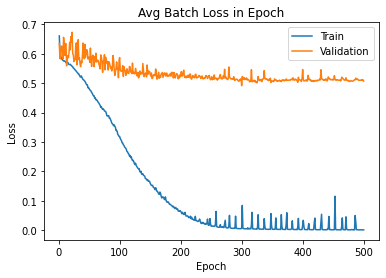

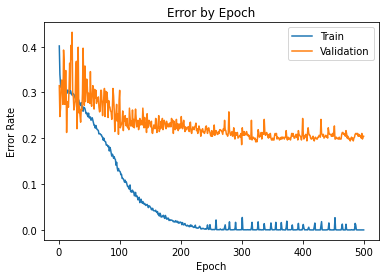

In [ ]:
model = ClassificationNetA()
model.to(device)

train_net_classification(model, balanced_train, val, bs=16, lr=0.001, wd=0, epochs=500, save_best=True, save_curves=True)

## Evaluation

### Load Model

In [26]:
# model_name = get_model_name('ClassificationNetA', 16, 0.00025, 0, 948) + '_error18.61'
MODEL_INFO_PATH = "/content/drive/My Drive/UofT/4th Year/APS360/Project/Hit-Song-Prediction/Models/"
model_name = "model_RakanNetA_bs16_lr0.001_wd0_epoch300_error18.61"
loaded_model = RakanNetA()
state = torch.load(MODEL_INFO_PATH + model_name)
loaded_model.load_state_dict(state)
loaded_model.normalization_values = torch.load(MODEL_INFO_PATH + model_name+"_NORMALIZATION")
if torch.cuda.is_available():
  loaded_model.cuda()
loaded_model.eval()

RakanNetA(
  (layers): Sequential(
    (0): Linear(in_features=42, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)

In [ ]:
loaded_model = model
loaded_model.eval()
if torch.cuda.is_available():
  loaded_model.cuda()

### Helper Functions

In [27]:
def get_baseline_classification_error(df, baseline_cutoff=hit_cutoff):
  total_error = 0
  correct = (df.hit == (df.avg_popularity_artist_top_tracks*100 > baseline_cutoff)).sum()
  # correct = (df.hit == (df.max_artist_popularity*100 > hit_cutoff)).sum()
  error_rate = 1 - (correct/df.shape[0])
  return error_rate

#--------------------------------------------------------------------------------------------------------
def get_confusion_matrix(model, data):
  model.eval()
  data_loader = torch.utils.data.DataLoader(data, batch_size=100)

  matrix = np.zeros(shape=(2,2))

  total_error = 0
  for features, targets in data_loader:
    features = features.to(device)
    targets = targets.to(device)

    targets = targets.squeeze(1).long()

    out = model(features)
    out = torch.softmax(out, dim=1)

    # Non-hit Correct
    matrix[0,0] += ((out.argmax(dim=1) == 0) * (targets == 0)).sum().item()
    # Hit Correct
    matrix[1,1] += ((out.argmax(dim=1) == 1) * (targets == 1)).sum().item()
    # Hit Incorrect (False Negative)
    matrix[0,1] += ((out.argmax(dim=1) == 0) * (targets == 1)).sum().item()
    # Non-Hit Incorrect (False Positive)
    matrix[1,0] += ((out.argmax(dim=1) == 1) * (targets == 0)).sum().item()
  
  return matrix

def get_baseline_confusion(df, baseline_cutoff=hit_cutoff):
  total_error = 0
  matrix = np.zeros(shape=(2,2))

  # Non-hit Correct
  matrix[0,0] += ((df.avg_popularity_artist_top_tracks*100 <= baseline_cutoff) & (df.hit == 0)).sum().item()
  # Hit Correct
  matrix[1,1] += ((df.avg_popularity_artist_top_tracks*100 > baseline_cutoff) & (df.hit == 1)).sum().item()
  # Hit Incorrect (False Negative)
  matrix[0,1] += ((df.avg_popularity_artist_top_tracks*100 <= baseline_cutoff) & (df.hit == 1)).sum().item()
  # Non-Hit Incorrect (False Positive)
  matrix[1,0] += ((df.avg_popularity_artist_top_tracks*100 > baseline_cutoff) & (df.hit == 0)).sum().item()

  return matrix

def print_confusion_matrix(matrix):
  print(f"--------------------------------------")
  print(f"                   Actual")
  print(f"                  0      1")
  print(f"Predicted  0    {round(matrix[0,0]*100,2)}   {round(matrix[0,1]*100,2)}")
  print(f"           1    {round(matrix[1,0]*100,2)}   {round(matrix[1,1]*100,2)}")
  print(f"--------------------------------------")

### Model Accuracy

In [36]:
eval_df = test_df.copy()
pred_list = []
for i,x in eval_df.iterrows():
  out = loaded_model(torch.FloatTensor(np.array(x[features]).astype(float)).to(device))
  sm_out = torch.softmax(out, dim=0)
  pred_list.append(out.argmax(dim=0).item()) 

pred_series = pd.Series(np.array(pred_list))
eval_df['prediction'] = pred_series.iloc[:].values

incorrect = eval_df[eval_df.hit != eval_df.prediction]
# incorrect_popularities = np.array(incorrect.popularity.values)
# incorrect_pop = np.array(incorrect.genres_pop.values).sum()
# incorrect_rock = np.array(incorrect.genres_rock.values).sum()
# incorrect_hiphop = np.array(incorrect["genres_hip hop"].values).sum()
# incorrect_rap = np.array(incorrect.genres_rap.values).sum()
eval_df_averages = eval_df[features].mean()
correct_averages = eval_df[eval_df.hit == eval_df.prediction][features].mean()
incorrect_averages = incorrect[features].mean()
print(correct_averages)
print(incorrect_averages)
print(correct_averages - incorrect_averages)

# num_pop = eval_df.genres_pop.sum()
# num_rock = eval_df.genres_rock.sum()
# num_hiphop = eval_df["genres_hip hop"].sum()
# num_rap = eval_df.genres_rap.sum()

# print(incorrect.shape)
# print(incorrect_pop/num_pop)
# print(incorrect_rock/num_rock)
# print(incorrect_hiphop/num_hiphop)
# print(incorrect_rap/num_rap)

# plt.hist(abs(hit_cutoff - incorrect_popularities), bins=range(0,100))
# plt.title('Incorrect Prediction Popularities')
# plt.xlabel('Difference from Hit Cutoff')
# plt.ylabel('Number of Incorrect Predictions')
# plt.show()

key                                                   0.435945
mode                                                  0.608696
time_signature                                        0.788235
duration                                              0.494027
acousticness                                          0.256668
danceability                                          0.617422
energy                                                0.609320
instrumentalness                                      0.036775
liveness                                              0.188744
loudness                                              0.817597
speechiness                                           0.144302
valence                                               0.453136
tempo                                                 0.552633
explicit                                              0.460358
release_date                                          0.100597
artist_followers                                      0

In [ ]:
eval_df[eval_df.hit == 1].iloc[72]

key                                                                   0.0909091
mode                                                                          0
time_signature                                                              0.8
duration                                                                 0.8826
acousticness                                                              0.123
danceability                                                              0.698
energy                                                                    0.454
instrumentalness                                                              0
liveness                                                                  0.155
loudness                                                               0.838946
speechiness                                                               0.151
valence                                                                   0.137
tempo                                   

In [ ]:
eval_df[eval_df.hit == 1].iloc[19]

key                                                   0.0909091
mode                                                          0
time_signature                                              0.8
duration                                               0.278888
acousticness                                           0.000282
danceability                                              0.908
energy                                                    0.621
instrumentalness                                       5.39e-05
liveness                                                 0.0958
loudness                                               0.842378
speechiness                                               0.102
valence                                                   0.421
tempo                                                  0.681561
name                                                    HUMBLE.
explicit                                                      1
release_date                            

In [ ]:
eval_df.iloc[163]

key                                                               0.636364
mode                                                                     0
time_signature                                                         0.8
duration                                                          0.305067
acousticness                                                          0.23
danceability                                                         0.257
energy                                                               0.455
instrumentalness                                                         0
liveness                                                             0.104
loudness                                                          0.766155
speechiness                                                         0.0385
valence                                                              0.198
tempo                                                             0.265971
name                     

In [ ]:
error = get_error_classification(loaded_model, balanced_train)
print(f"Balanced Training Error: {round(error*100,2)}%")

error = get_error_classification(loaded_model, train)
print(f"Training Error: {round(error*100,2)}%")

error = get_error_classification(loaded_model, val)
print(f"Validation Error: {round(error*100,2)}%")

error = get_error_classification(loaded_model, test)
print(f"Testing Error: {round(error*100,2)}%")

error = get_error_classification(loaded_model, full_dataset)
print(f"Full Dataset Error: {round(error*100,2)}%")

Balanced Training Error: 4.66%
Training Error: 2.37%
Validation Error: 18.61%
Testing Error: 20.2%
Full Dataset Error: 7.48%


In [ ]:
print(f"\nBalanced Training Matrix:")
matrix = get_confusion_matrix(loaded_model, balanced_train) / len(balanced_train)
print_confusion_matrix(matrix)


print(f"\nTraining Matrix:")
matrix = get_confusion_matrix(loaded_model, train) / len(train)
print_confusion_matrix(matrix)


print(f"\nValidation Matrix:")
matrix = get_confusion_matrix(loaded_model, val) / len(val)
print_confusion_matrix(matrix)


print(f"\nTesting Matrix:")
matrix = get_confusion_matrix(loaded_model, test) / len(test)
print_confusion_matrix(matrix)


print(f"\nFull Dataset Matrix:")
matrix = get_confusion_matrix(loaded_model, full_dataset) / len(full_dataset)
print_confusion_matrix(matrix)


Balanced Training Matrix:
--------------------------------------
                   Actual
                  0      1
Predicted  0    49.33   3.99
           1    0.67   46.01
--------------------------------------

Training Matrix:
--------------------------------------
                   Actual
                  0      1
Predicted  0    83.44   1.23
           1    1.14   14.2
--------------------------------------

Validation Matrix:
--------------------------------------
                   Actual
                  0      1
Predicted  0    77.51   10.43
           1    8.18   3.89
--------------------------------------

Testing Matrix:
--------------------------------------
                   Actual
                  0      1
Predicted  0    74.29   10.0
           1    10.2   5.51
--------------------------------------

Full Dataset Matrix:
--------------------------------------
                   Actual
                  0      1
Predicted  0    81.17   3.93
           1    3.56 

### Baseline Model Accuracy

Balanced Training Baseline Error: 33.32%
Training Baseline Error: 29.71%
Validation Baseline Error: 27.81%
Testing Baseline Error: 27.76%
Full Dataset Baseline Error: 29.13%


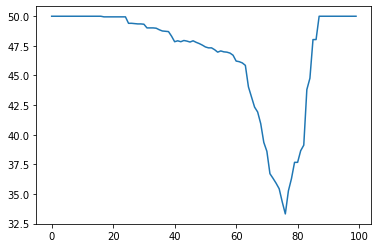

In [ ]:
baseline_cutoff = 76

baseline_error = get_baseline_classification_error(balanced_train_df, baseline_cutoff=baseline_cutoff)
print(f"Balanced Training Baseline Error: {round(baseline_error*100,2)}%")

baseline_error = get_baseline_classification_error(train_df, baseline_cutoff=baseline_cutoff)
print(f"Training Baseline Error: {round(baseline_error*100,2)}%")

baseline_error = get_baseline_classification_error(val_df, baseline_cutoff=baseline_cutoff)
print(f"Validation Baseline Error: {round(baseline_error*100,2)}%")

baseline_error = get_baseline_classification_error(test_df, baseline_cutoff=baseline_cutoff)
print(f"Testing Baseline Error: {round(baseline_error*100,2)}%")

baseline_error = get_baseline_classification_error(pd.concat([train_df, val_df, test_df], axis=0), baseline_cutoff=baseline_cutoff)
print(f"Full Dataset Baseline Error: {round(baseline_error*100,2)}%")

baseline_errors = []
for cutoff in range (0,100):
  baseline_errors.append(get_baseline_classification_error(balanced_train_df, baseline_cutoff=cutoff)*100)

plt.plot(range(0,100), np.array(baseline_errors))


In [ ]:
print(f"\nBalanced Training Matrix:")
matrix = get_baseline_confusion(balanced_train_df, baseline_cutoff=baseline_cutoff) / balanced_train_df.shape[0]
print_confusion_matrix(matrix)


print(f"\nTraining Matrix:")
matrix = get_baseline_confusion(train_df, baseline_cutoff=baseline_cutoff) / train_df.shape[0]
print_confusion_matrix(matrix)


print(f"\nValidation Matrix:")
matrix = get_baseline_confusion(val_df, baseline_cutoff=baseline_cutoff) / val_df.shape[0]
print_confusion_matrix(matrix)


print(f"\Testing Matrix:")
matrix = get_baseline_confusion(test_df, baseline_cutoff=baseline_cutoff) / test_df.shape[0]
print_confusion_matrix(matrix)


print(f"\nFull Dataset Matrix:")
matrix = get_baseline_confusion(full_df, baseline_cutoff=baseline_cutoff) / (train_df.shape[0] + val_df.shape[0] + test_df.shape[0])
print_confusion_matrix(matrix)


Balanced Training Matrix:
--------------------------------------
                   Actual
                  0      1
Predicted  0    35.98   19.3
           1    14.02   30.7
--------------------------------------

Training Matrix:
--------------------------------------
                   Actual
                  0      1
Predicted  0    60.87   6.0
           1    23.71   9.42
--------------------------------------

Validation Matrix:
--------------------------------------
                   Actual
                  0      1
Predicted  0    64.42   6.54
           1    21.27   7.77
--------------------------------------
\Testing Matrix:
--------------------------------------
                   Actual
                  0      1
Predicted  0    62.45   5.71
           1    22.04   9.8
--------------------------------------

Full Dataset Matrix:
--------------------------------------
                   Actual
                  0      1
Predicted  0    61.64   6.04
           1    23.09

## Evaluation on different dataset





### Loading/Cleaning Data

In [28]:
# TSwift4Life
new_dataset_name = "4tVDvvvEggMTo8S7OwaLEu"

new_dataset_df = load_playlist_df(new_dataset_name)

Loaded playlist from file: /content/drive/My Drive/UofT/4th Year/APS360/Project/Hit-Song-Prediction/playlist_4tVDvvvEggMTo8S7OwaLEu


In [29]:
normalized_new_dataset_df = normalize_function(new_dataset_df.copy(), loaded_model.normalization_values)
normalized_new_dataset_df[features] = normalized_new_dataset_df[features].astype(float)

In [30]:
new_dataset = SpotifyTracksDataset(normalized_new_dataset_df, features, dataset_target)

### Evaluating

In [33]:
predictions = []
for i,x in normalized_new_dataset_df.iterrows():
  out = loaded_model(torch.FloatTensor(np.array(x[features]).astype(float)).to(device))
  sm_out = torch.softmax(out, dim=0)
  predictions.append(sm_out.argmax(dim=0).item()) 

predictions_series = pd.Series(np.array(predictions))
normalized_new_dataset_df['prediction'] = predictions_series.iloc[:].values
normalized_new_dataset_df['name_'] = normalized_new_dataset_df.name
normalized_new_dataset_df


,key,mode,time_signature,duration,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,name,explicit,release_date,artist_followers,max_artist_popularity,avg_popularity_artist_top_tracks,avg_duration_artist_top_tracks,avg_acousticness_artist_top_tracks,avg_danceability_artist_top_tracks,avg_energy_artist_top_tracks,avg_instrumentalness_artist_top_tracks,avg_liveness_artist_top_tracks,avg_loudness_artist_top_tracks,avg_speechiness_artist_top_tracks,avg_valence_artist_top_tracks,avg_tempo_artist_top_tracks,change_from_avg_duration_artist_top_tracks,change_from_avg_acousticness_artist_top_tracks,change_from_avg_danceability_artist_top_tracks,change_from_avg_energy_artist_top_tracks,change_from_avg_instrumentalness_artist_top_tracks,change_from_avg_liveness_artist_top_tracks,change_from_avg_loudness_artist_top_tracks,change_from_avg_speechiness_artist_top_tracks,change_from_avg_valence_artist_top_tracks,change_from_avg_tempo_artist_top_tracks,popularity,hit,genres_pop,genres_hip hop,genres_rock,genres_rap,prediction,name_
0,0.000000,1.0,0.8,0.518900,0.757,0.777,0.357,0.000007,0.1080,0.833537,0.0522,0.172,0.635546,the 1,1.0,0.0,0.470868,0.97,0.8700,0.697621,0.6622,0.5679,0.46950,0.000294,0.117380,0.761790,0.037950,0.375100,0.516853,0.178721,0.0948,0.2091,0.11250,0.000286,0.009380,0.071747,0.014250,0.203100,0.118692,89,1,1.0,0.0,0.0,0.0,1,the 1
1,0.000000,0.0,0.8,0.730445,0.537,0.613,0.581,0.000345,0.2500,0.785669,0.0424,0.551,0.590793,cardigan,0.0,0.0,0.470868,0.97,0.8700,0.697621,0.6622,0.5679,0.46950,0.000294,0.117380,0.761790,0.037950,0.375100,0.516853,0.032824,0.1252,0.0451,0.11150,0.000051,0.132620,0.023879,0.004450,0.175900,0.073940,90,1,1.0,0.0,0.0,0.0,1,cardigan
2,0.636364,1.0,0.8,0.668651,0.467,0.686,0.662,0.002300,0.1090,0.788082,0.0413,0.706,0.672070,the last great american dynasty,1.0,0.0,0.470868,0.97,0.8700,0.697621,0.6622,0.5679,0.46950,0.000294,0.117380,0.761790,0.037950,0.375100,0.516853,0.028969,0.1952,0.1181,0.19250,0.002006,0.008380,0.026293,0.003350,0.330900,0.155217,87,1,1.0,0.0,0.0,0.0,0,the last great american dynasty
3,0.545455,1.0,0.8,1.000000,0.778,0.298,0.380,0.000056,0.1100,0.790380,0.0287,0.152,0.343491,exile (feat. Bon Iver),0.0,0.0,0.470868,0.97,0.7615,0.765191,0.7691,0.5255,0.36756,0.062803,0.116495,0.693688,0.037665,0.282115,0.532051,0.297815,0.0089,0.2275,0.01244,0.062747,0.006495,0.096692,0.008965,0.130115,0.188560,89,1,1.0,0.0,0.0,0.0,0,exile (feat. Bon Iver)
4,0.000000,1.0,0.8,0.848343,0.806,0.456,0.263,0.000000,0.0749,0.726284,0.0332,0.111,0.590007,my tears ricochet,0.0,0.0,0.470868,0.97,0.8700,0.697621,0.6622,0.5679,0.46950,0.000294,0.117380,0.761790,0.037950,0.375100,0.516853,0.150722,0.1438,0.1119,0.20650,0.000294,0.042480,0.035506,0.004750,0.264100,0.073154,87,1,1.0,0.0,0.0,0.0,1,my tears ricochet
5,0.181818,1.0,0.8,0.509704,0.687,0.553,0.413,0.000002,0.0594,0.743529,0.0334,0.379,0.500261,mirrorball,0.0,0.0,0.470868,0.97,0.8700,0.697621,0.6622,0.5679,0.46950,0.000294,0.117380,0.761790,0.037950,0.375100,0.516853,0.187917,0.0248,0.0149,0.05650,0.000291,0.057980,0.018260,0.004550,0.003900,0.016592,86,1,1.0,0.0,0.0,0.0,1,mirrorball
6,0.363636,1.0,0.8,0.509192,0.900,0.596,0.488,0.000027,0.0910,0.722242,0.0274,0.415,0.431288,seven,0.0,0.0,0.470868,0.97,0.8700,0.697621,0.6622,0.5679,0.46950,0.000294,0.117380,0.761790,0.037950,0.375100,0.516853,0.188429,0.2378,0.0281,0.01850,0.000267,0.026380,0.039548,0.010550,0.039900,0.085566,86,1,1.0,0.0,0.0,0.0,1,seven
7,0.454545,1.0,0.8,0.891860,0.538,0.532,0.623,0.000073,0.0925,0.767638,0.0331,0.403,0.408621,august,0.0,0.0,0.470868,0.97,0.8700,0.697621,0.6622,0.5679,0.46950,0.000294,0.117380,0.761790,0.037950,0.375100,0.516853,0.194240,0.1242,0.0359,0.15350,0.000221,0.024880,0.005848,0.004850,0.027900,0.108233,86,1,1.0,0.0,0.0,0.0,0,august
8,0.818182,1.0,0.8,0.409511,0.314,0.515,0.476,0.000047,0.1710,0.749171,0.0328,0.412,0.617386,this is me trying,0.0,0.0,0.470868,0.97,0.8700,0.697621,0.6622,0.5679,0.46950,0.000294,0.

#### Model Accuracy

In [ ]:
error = get_error_classification(loaded_model, new_dataset)
print(f"New Dataset Error: {round(error*100,2)}%")

New Dataset Error: 31.25%


In [ ]:
print(f"\nFull Dataset Matrix:")
matrix = get_confusion_matrix(loaded_model, new_dataset) / len(new_dataset)
print_confusion_matrix(matrix)


Full Dataset Matrix:
--------------------------------------
                   Actual
                  0      1
Predicted  0    0.0   31.25
           1    0.0   68.75
--------------------------------------


#### Baseline Model Accuracy

In [ ]:
baseline_error = get_baseline_classification_error(normalized_new_dataset_df)
print(f"New Dataset Baseline Error: {round(baseline_error*100,2)}%")

New Dataset Baseline Error: 0.0%


In [ ]:
print(f"\nFull Dataset Matrix:")
matrix = get_baseline_confusion(normalized_new_dataset_df) / normalized_new_dataset_df.shape[0]
print_confusion_matrix(matrix)


Full Dataset Matrix:
--------------------------------------
                   Actual
                  0      1
Predicted  0    0.0   0.0
           1    0.0   100.0
--------------------------------------


# Regression Stuff

### Model

In [ ]:
class RegressionNet(nn.Module):
  def __init__(self):
    super(RegressionNet, self).__init__()
    
    self.layers = nn.Sequential(
        nn.Linear(len(features), 100),
        nn.ReLU(),
        nn.Linear(100,50),
        nn.ReLU(),
        nn.Linear(50,10),
        nn.ReLU(),
        nn.Linear(10,1)
    ).to(device)


  def forward(self, x):
    x = self.layers(x)
    return x

### Training

In [ ]:
def get_error_regression(model, data):
  model.eval()
  data_loader = torch.utils.data.DataLoader(data, batch_size=100)
  total_error = 0
  for features, targets in data_loader:
    features = features.to(device)
    targets = targets.to(device)

    out = model(features)
    total_error += (targets - out.clamp(min=0,max=100)).abs().sum().item()
  
  error_rate = total_error/len(data)
  return error_rate

def get_stats_regression(model, data, criterion, bs=100):
  model.eval()
  data_loader = torch.utils.data.DataLoader(data, batch_size=bs)

  total_error = 0.0
  total_loss = 0.0
  for i, batch in enumerate(data_loader, 1):
    features, targets = batch
    features = features.to(device)
    targets = targets.to(device)

    out = model(features)
    total_error += (targets - out.clamp(min=0,max=100)).abs().sum().item()

    loss = criterion(out, targets)
    total_loss += loss.item()
  
  avg_loss = total_loss / i
  error = total_error/len(data)
  return error, avg_loss

In [ ]:
def train_net_regression(model, train_data, valid_data, bs=50, lr=0.01, wd=0, epochs=5):
  model.train()
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)

  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

  train_losses, valid_losses, train_errors, val_errors = [], [], [], []

  for epoch in range(1, epochs + 1):
    epoch_error = 0.0
    epoch_loss = 0.0
    for i, batch in enumerate(train_loader, 1):
      features, targets = batch

      features = features.to(device)
      targets = targets.to(device)
      
      optimizer.zero_grad()
      out = model(features)

      loss = criterion(out, targets)
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      epoch_error += (targets - out.clamp(min=0,max=100)).abs().sum().item()

    epoch_loss = epoch_loss / i
    train_error_rate = epoch_error / len(train_data)
    val_error_rate, val_loss = get_stats_regression(model, valid_data, criterion, bs=bs)
    model.train()

    train_losses.append(epoch_loss)
    valid_losses.append(val_loss)
    train_errors.append(train_error_rate)
    val_errors.append(val_error_rate)
    
    
    print(f"Epoch {epoch}")
    print(f"  Train Error: {train_error_rate}")
    print(f"  Valid Error: {val_error_rate}")
    print(f"  Train Loss: {epoch_loss}")
    print(f"  Valid Loss: {val_loss}")
    print()
    predict_some(model, train_data, 2)
    print()
    predict_some(model, valid_data, 2)
    print("\n")

  plot_data([train_losses, valid_losses], multiple_series=True, labels=["Train", "Validation"],
            title="Avg Batch Loss in Epoch", xlabel='Epoch', ylabel='Loss')
  plot_data([train_errors, val_errors], multiple_series=True, labels=["Train", "Validation"], 
            title="Avg Error by Epoch", xlabel='Epoch', ylabel='Avg Error')

In [ ]:
model = RegressionNet()
model.to(device)

train_net_regression(model, train, val, bs=512, lr=0.0001, wd=0, epochs=1000)

NameError: ignored

### Evaluation


In [ ]:
def get_baseline_regression_error(df):
  total_error = 0
  errors = (df.max_artist_popularity*100 - df.popularity).abs()
  errors = (df.avg_popularity_artist_top_tracks*100 - df.popularity).abs()
  total_error = errors.sum()
  error_rate = total_error/df.shape[0]
  return error_rate

In [ ]:
error = get_error_regression(model, test)
print(error)
error = get_error_regression(model, full_dataset)
print(error)

1.3287614371559837
1.3246404070379347


In [ ]:
baseline_error = get_baseline_regression_error(train_df)
print(baseline_error)
baseline_error = get_baseline_regression_error(val_df)
print(baseline_error)
baseline_error = get_baseline_regression_error(test_df)
print(baseline_error)

baseline_error = get_baseline_regression_error(regression_df)
print(baseline_error)

19.919915253461415
20.68003212275486
20.30826438249911
20.092127926842924
